<a href="https://colab.research.google.com/github/andreeadeac22/IFT6760H20/blob/master/Assignment_2_Template_Part_2_IFT6760C_H20_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Seasonal Outbreaks of Measles

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

The following example is taken from [Numerical solution of boundary value problems for ordinary differential equations](https://books.google.ca/books?id=0RvOrnO4WgwC&lpg=PP1&dq=Numerical%20solution%20of%20boundary%20value%20problems%20for%20ordinary%20differential%20equations%20Robert%20D.%20Russell&pg=PA14#v=onepage&q=measles&f=false) by Uri M. Ascher , Robert M. M. Mattheij and Robert D. Russell. According to the bibliographical remarks, this model is based on [Schwartz (1983)](https://doi.org/10.1137/0720008); you can in indeed find the description of this model on page 116 of the Schwartz (1983) paper.  And if you read carefully the Schwartz (1983) paper, you finally see that this model is based on [London and Yorke (1973)](https://doi.org/10.1093/oxfordjournals.aje.a121575
)

This model assumes that population stays constant and can be partitioned into *susceptible* cases $S(t)$ (people who can contract measles), *infectives* $I(t)$ (people who can infect other people), *latents* $L(t)$ (people who have measles but can't spread it yet) and *immunes* $M(t)$ (recovered cases). Furthermore, it is assumed that that the disease is non lethal and that the births exactly counterbalance all other deaths. In this problem, we set the birth rate $\mu$ to $2\%$ of the total population $N$. At all times for $t \in [0, 1]$, we have: 
\begin{align*}
S(t) + I(t) + L(t) + M(t) = N \enspace ,
\end{align*}
where $N$ is the total population. Furthermore, the dynamics for this model are given by: 
\begin{align*}
\dot{x}_1 &= \mu - \beta(t)x_1x_3 \\
\dot{x}_2 &= \beta(t)x_1x_3 - \frac{x_2}{\lambda} \\
\dot{x}_3 &= \frac{x_2}{\lambda} - \frac{x_3}{\eta}, \enspace 0 < t < 1 \\
\beta(t) &= \beta_0(1 + \cos(2\pi t))\enspace .
\end{align*}
The boundary condition consists in: 
\begin{align*}
x(1) - x(0) = 0 \enspace .
\end{align*}
This means that we want to find a value for the initial conditions such that at the end of the interval at $t=1$ we got back to the same point: a periodic solution. In this model, $\eta=0.01$ is the mean length of the infectious period in years (3 to 4 days) and $\lambda=0.00279$ is the mean length of the latent period (about 10 to 11 days). The function $\beta(t)$ gives us the *contact rate*, which London and Yorke (1973) desribe as the proportion of susceptible cases that are contacted every year by an average infective individual. 

In [0]:
def make_measles_bvp(mu=0.02, lmbda=0.0279, eta=0.01, beta0=1575.):
  def measles_dynamics(t, x):
    x1, x2, x3 = x 
    beta_t = beta0*(1. + np.cos(2*np.pi*t))
    dot_x1 = mu - beta_t*x1*x3 
    dot_x2 = beta_t*x1*x3 - x2/lmbda
    dot_x3 = x2/lmbda - x3/eta
    return np.asarray((dot_x1, dot_x2, dot_x3))

  def boundary_condition(xinit, xfinal):
    return xfinal - xinit

  return measles_dynamics, boundary_condition, 0., 1.

We can solve this BVP using [scipy.integrate.solve_bvp](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.solve_bvp.html) which according to the documentation uses a 4-th order collocation approach described in [Kierzenka and Shampine (2001)](https://dl.acm.org/doi/pdf/10.1145/502800.502801).

In [4]:
from scipy.integrate import solve_bvp

dynamics, boundary_condition, initial_time, terminal_time = make_measles_bvp()

mesh = np.linspace(initial_time, terminal_time, 100)
guess = np.ones((mesh.shape[0], 3))*np.array([1, 1, 1])
solution = solve_bvp(dynamics, boundary_condition, mesh, guess.T)
print(solution.y[:,-1])

[7.52362906e-02 1.79844367e-05 4.97392853e-06]


We can then reproduce the [plot](https://www.nag.co.uk/numeric/mb/nagdoc_mb/manual_25_1/pdf/d02/d02tv.pdf) found in the documentation of the [NAG library](https://www.nag.com/content/nag-library). In this plot, the infectious trajectory is in shown on the left y-axis while the infective and latent trajectories are shown on a semi log scale on the right y-axis.

In [0]:
def plot_measles_bvp(time, x):
  fig, ax = plt.subplots()

  ax.grid(True)
  ax.set_xlabel('Time')
  ax.set_title('Model of Spread of Measles')

  ax.set_ylabel('Susceptible', color='tab:blue')
  ax.tick_params(axis='y', labelcolor='tab:blue')
  ax.set_ylim([0.06, 0.08])
  ax.set_yticks(np.linspace(0.06, 0.08, 5))
  ax.plot(time, x[0,:], c='tab:blue', label='Susceptible')
  ax.legend(loc='lower left')

  rhs_ax = ax.twinx()
  rhs_ax.set_ylim([1e-10, 1])
  rhs_ax.set_ylabel('Infective and Latent', color='tab:orange')
  rhs_ax.tick_params(axis='y', labelcolor='tab:orange')
  rhs_ax.semilogy(time, x[1,:], c='tab:orange', linestyle='dotted', label='Infective')
  rhs_ax.semilogy(time, x[2,:], c='tab:orange', linestyle=(0, (3, 1, 1, 1, 1, 1)), label='Latent')
  rhs_ax.legend(loc='upper right')

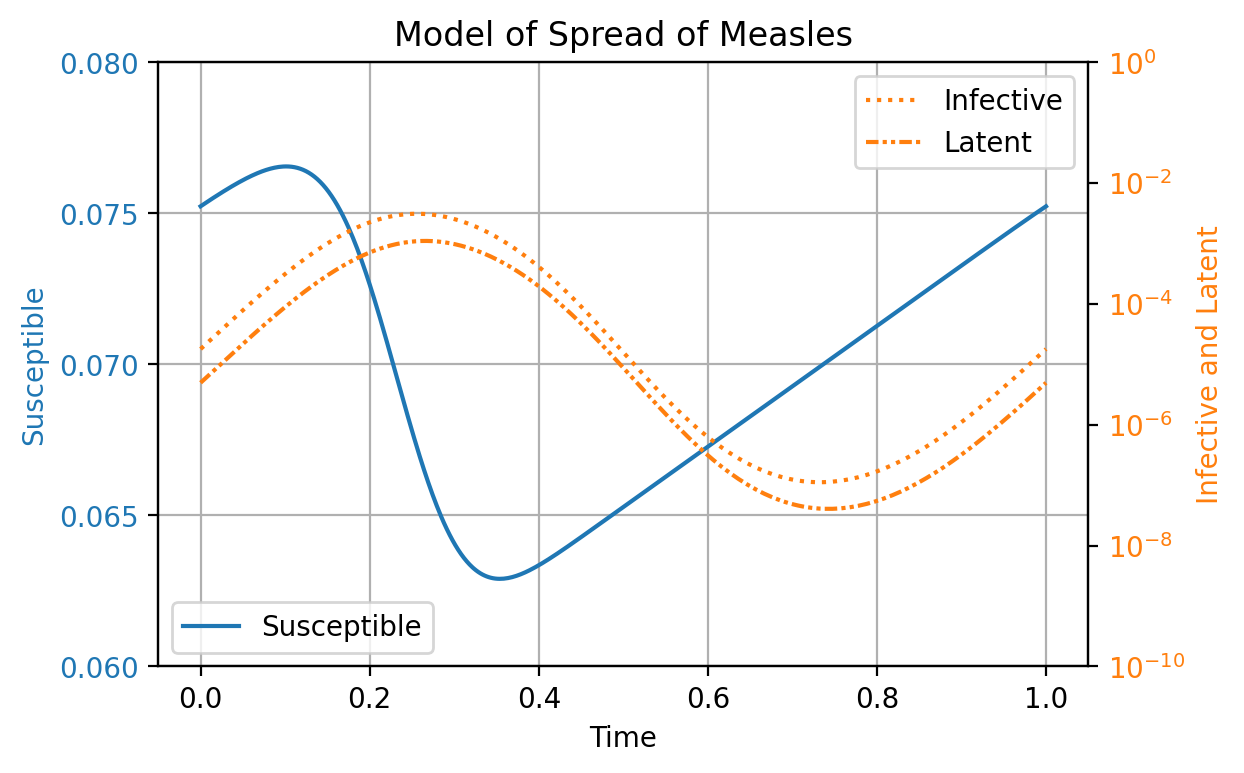

In [6]:
plot_measles_bvp(solution.x, solution.y)

# Single Shooting Method

The main idea in shooting methods is amenable to the *reparameterization* idea which we have encountered in the transformation of constrained discrete-time optimal control problem into an unconstrained one, or in implicit differentiation methods. The general formulation for boundary value problems is of the form: 
\begin{align*}
&\dot{x} = f(x(t), t), \enspace  a < t < b\\
&\psi(x(a), x(b)) = 0 \enspace ,
\end{align*}
where $\psi$ is a boundary condition. That is, we are trying to find initial conditions such that when the system evolves from that state $x(a)$ at time $t=a$ until $t=b$, then upon inserting both the initial and terminal states $x(b)$ into $\psi$, we get $\psi(x(a), x(b)) = 0$. Rather than working with two unknowns $x(a)$ and $x(b)$, we can apply the reparametrization idea to get: 
\begin{align*}
\psi(x(a), x(b)) = \psi(x(a), \phi_b(a)) \enspace ,
\end{align*}
where $\phi_b(a)$ is the solution to the initial value problem starting from the state $x(a)$ at time $t=a$ until $t=b$. In most cases, a closed-form solution for $\phi$ won't be available and we are going to have to use numerical integration. In this case, you can think of $\phi$ as an *algorithm* which we are going to differentiate through.

## Question


Implement the shooting method by writing a constraint function amenable to [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). You can use the following  Runge-Kutta integrator to implement the $\phi$ function in the above problem formulation:

In [0]:
def rk4_step(f, t, x, h):
  k1 = h*f(t, x)
  k2 = h*f(t + h/2, x + k1/2)
  k3 = h*f(t + h/2, x + k2/2)
  k4 = h*f(t + h, x + k3)
  return (1/6)*(k1 + 2*k2 + 2*k3 + k4)


def integrate_equal(method, f, x0, start, stop, num):
  x, t = x0, start
  yield t, x

  h = (stop - start)/(num - 1)
  for _ in range(num - 1):
    x = x + method(f, t, x, h)
    t = t + h
    yield t, x

Use this numerical integration function to solve the IVP corresponding to every candidate initial condition within the following constraint function:

In [0]:
from scipy.optimize import minimize

def make_single_shooting(dynamics, boundary_condition, initial_time, terminal_time, nsteps):
  """
  Args:
    dynamics (callable): Function with signature f(t, x)
    boundary_condition (callable): Function with signature psi(xa, xb)
    initial_time (float): Initial time (t=a)
    terminal_time (float): Terminal time (t=b)
    nsteps (int): Number of numerical integration steps
  """
  def dummy_objective(x):
    """ Nothing to do here. Just to interface with the NLP solver"""
    return 1.

  def constraint(initial_condition):
    """ NLP constraint allowing the boundary condition to be satisfied
    """
    # Add your code here
    all_iterations = list(integrate_equal(rk4_step, dynamics, initial_condition,
                                      initial_time, terminal_time, nsteps))

    t_final, x_final = all_iterations[-1]
    
    return x_final - initial_condition

  return dummy_objective, constraint

The following should indicate ``success: True``. 

In [9]:
fun, constraint = make_single_shooting(*make_measles_bvp(), 100)
solution = minimize(fun, np.array([1e-2, 1e-3, 1e-4]), method='SLSQP', constraints={'type':'eq', 'fun':constraint})
print(solution)

     fun: 1.0
     jac: array([0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 190
     nit: 32
    njev: 32
  status: 0
 success: True
       x: array([7.52293371e-02, 1.80147440e-05, 4.98271319e-06])


The plot should also look identical to the one we obtained using Scipy's ``solve_bvp`` function.

In [0]:
def plot_solution(dynamics, initial_condition, initial_time, terminal_time, nsteps):
  data = np.asarray(list(integrate_equal(rk4_step, dynamics, initial_condition, initial_time, terminal_time, nsteps)))
  plot_measles_bvp(data[:,0], np.vstack(data[:,1]).T)

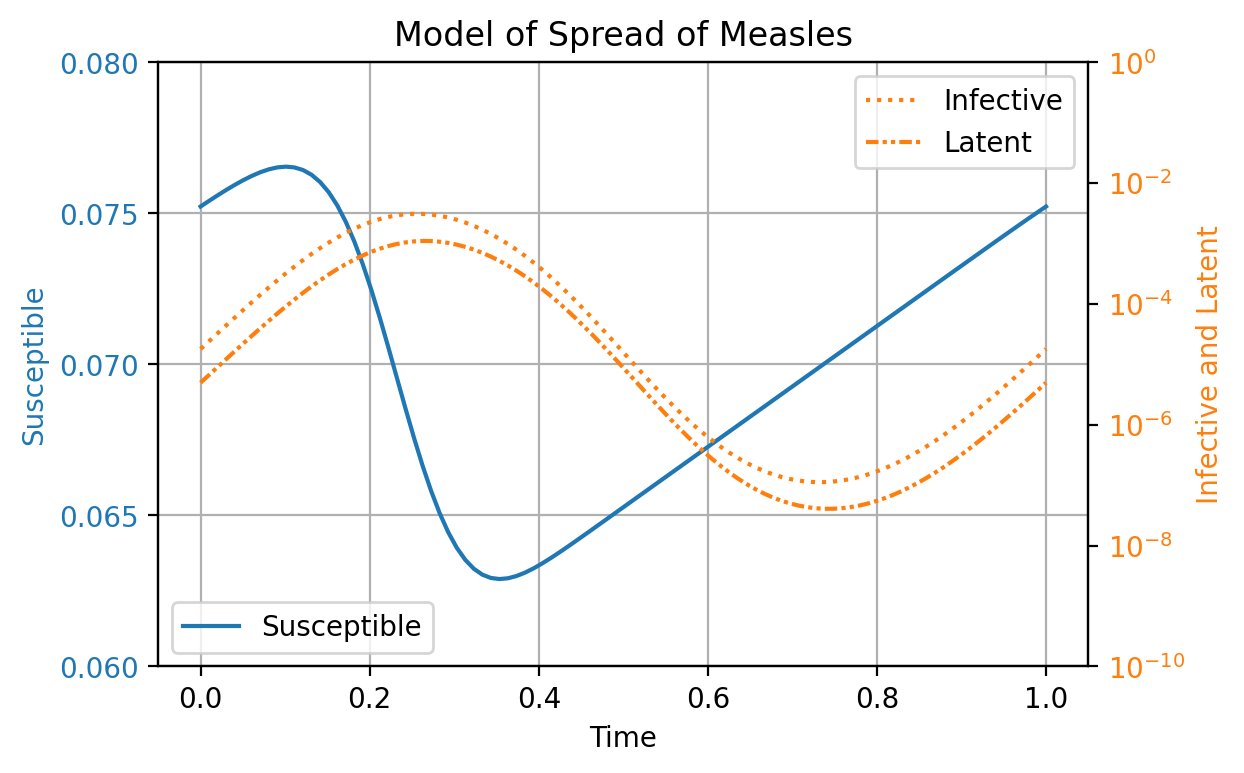

In [11]:
plot_solution(dynamics, solution.x, initial_time, terminal_time, 100)

# Multiple Shooting Methods

In multiple shooting methods, we pick $N$ intervals such that $a = t_1 < ... < t_{N} < t_{N+1} = b$ and view the initial conditions $x_{t_i}$ at the begining of interval as new decision variables in our NLP. We then solve the IVP of each interval and use the value of the terminal state within that interval $x_{t_{i+1}}$ to evaluate the *defect* associated with this particular *node*: the difference between $\phi_{t_{i+1}}(x_{t_i})$ and $x_{t_{i+1}}$. We can then concatenate all the defects into our constraint function together with the boundary condition:
\begin{align*}
h(x_{t_1}, ..., x_{t_N}) = \begin{bmatrix}
\phi_{t_{2}}(x_{t_1}) - x_{t_{2}} \\
\vdots \\
\phi_{t_{i+1}}(x_{t_i}) - x_{t_{i+1}}\\
\vdots \\
\phi_{t_{N}}(x_{t_{N-1}}) - x_{t_{N}} \\
\psi(x_a, \phi_{b}(x_{t_{N}})) 
\end{bmatrix} \enspace .
\end{align*}
In this formulation, we have as many decision variables in our NLP as we have intervals. If we have $N$ intervals, we then going to have $N-1$ defect constraints plus the boundary constraint for a total of $N$ contraints.


In [0]:
def make_multiple_shoooting(dynamics, boundary_condition, initial_time, terminal_time, number_nodes, number_subnodes):
  number_intervals = number_nodes - 1
  mesh = np.linspace(initial_time, terminal_time, number_nodes)
  
  def dummy_objective(initial_conditions):
    return 1.

  def constraint(node_values):
    # ADD YOUR CODE HERE
    all_constraints = []
    dim = int(len(node_values)/number_intervals)
    for i in range(number_intervals):
      initial_condition = node_values[dim*i:dim*i+dim]
      initial_time = mesh[i]
      terminal_time = mesh[i+1]
      all_iterations = list(integrate_equal(rk4_step, dynamics, initial_condition,
                                      initial_time, terminal_time, int(number_subnodes/number_nodes)))

      t_final, x_final = all_iterations[-1]
      if i < number_intervals-1: 
        next_initial_condition = node_values[dim*(i+1): dim*(i+1) + dim]
      else:
        next_initial_condition = node_values[:dim]
      
      all_constraints += [x_final - next_initial_condition]
  
    return np.concatenate(all_constraints)

  return dummy_objective, constraint

The following should return ``success: True``:

In [17]:
number_nodes = 3
number_subnodes = 100

fun, constraint = make_multiple_shoooting(*make_measles_bvp(), number_nodes, number_subnodes)
initial_node_values = np.ones((number_nodes-1, 3))*1e-3
solution = minimize(fun, np.ravel(initial_node_values), method='SLSQP', constraints={'type':'eq', 'fun':constraint})
print(solution)

     fun: 1.0
     jac: array([0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 240
     nit: 27
    njev: 27
  status: 0
 success: True
       x: array([7.52177867e-02, 1.80580614e-05, 4.99282560e-06, 6.52599049e-02,
       1.59235568e-05, 8.80252324e-06])


We can also verify graphically that we get the same solution:

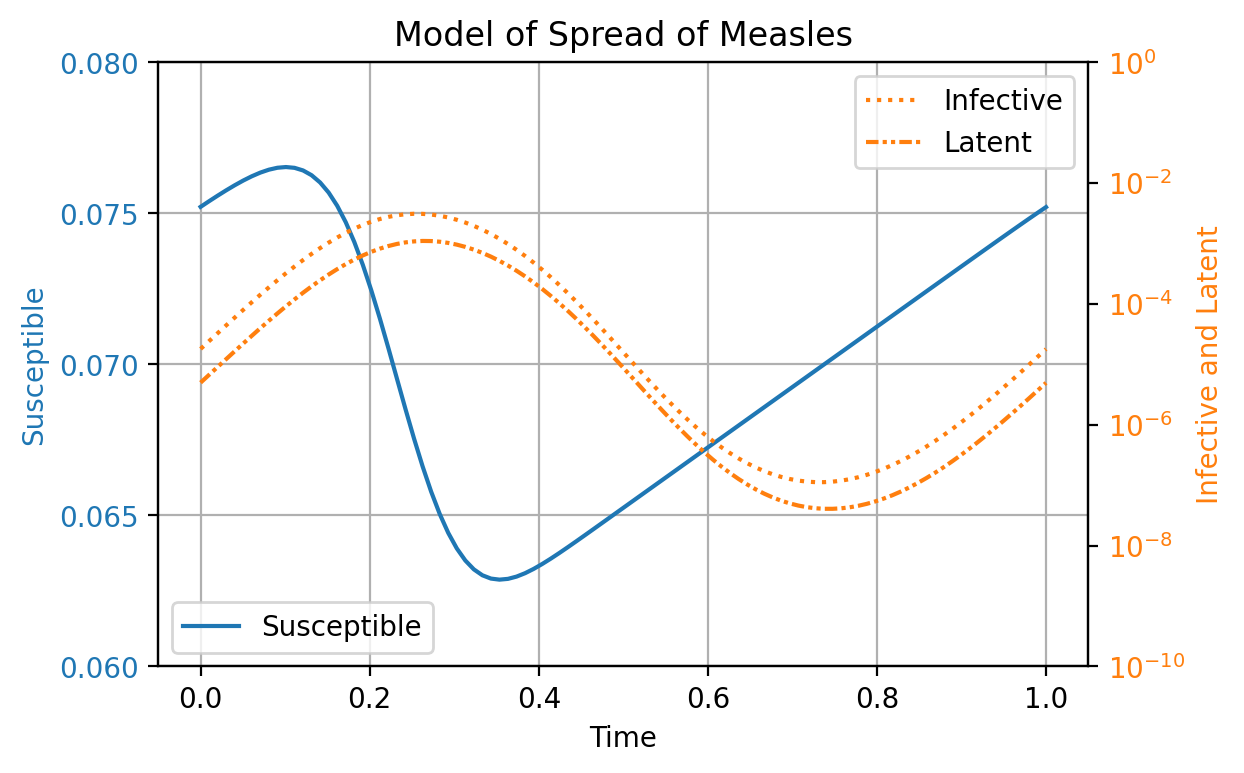

In [18]:
node_values = np.reshape(solution.x, (number_nodes-1, -1))
plot_solution(dynamics, node_values[0,:], initial_time, terminal_time, 100)